# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

2025-12-04 22:53:00.261007: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-04 22:53:03.483814: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-04 22:53:13.337682: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
# Si por alguna razón querés forzar CPU, descomenta esta línea:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

### 1. Selección del corpus de texto
Utilizaremos como dataset "Así habló Zaratustra", de Friedrich Nietzsche.

In [3]:
# descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs

In [4]:
raw_html = urllib.request.urlopen('https://www.textos.info/friedrich-nietzsche/asi-hablo-zaratustra/ebook')
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text + ' '

# pasar todo el texto a minúscula
article_text = article_text.lower()

In [5]:
# remover \xad \n
article_text = article_text.replace('\xad', '').replace('\n', '')


In [6]:
# en article text se encuentra el texto de todo el libro
article_text[:1000]

' cuando zaratustra tenía treinta años abandonó su patria y el lago de su patria y marchó a las montañas. allí gozó de su espíritu y de su soledad y durante diez años no se cansó de hacerlo. pero al fin su corazón se transformó y una mañana, levantándose con la aurora, se colocó delante del sol y le habló así: «¡tú gran astro! ¡qué sería de tu felicidad si no tuvieras a aquellos a quienes iluminas! durante diez años has venido subiendo hasta mi caverna: sin mí, mi águila y mi serpiente te habrías hartado de tu luz y de este camino. pero nosotros te aguardábamos cada mañana, te liberábamos de tu sobreabundancia y te bendecíamos por ello. ¡mira! estoy hastiado de mi sabiduría como la abeja que ha recogido demasiada miel, tengo necesidad de manos que se extiendan. me gustaría regalar y repartir hasta que los sabios entre los hombres hayan vuelto a regocijarse con su locura y los pobres, con su riqueza. para ello tengo que bajar a la profundidad como haces tú al atardecer, cuando traspones

In [7]:
# seleccionamos el tamaño de contexto
max_context_size = 100

### 2. Preprocesamiento, tokenización y construcción del dataset


Construcción del vocabulario de caracteres, tokenizción del texto a índices de caracteres, armado de secuencias de longitud fija, definición X e y en esquema many-to-many (target desplazado un paso) y separación de una porción del corpus para validación.


In [8]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [9]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)

In [10]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

64

In [11]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

In [12]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

In [13]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [14]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [15]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [16]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [17]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

In [18]:
vocab_size = len(chars_vocab)

### 3. Modelo de basado en SimpleRNN

El modelo recibe secuencias de caracteres codificados en one-hot mediante una capa CategoryEncoding aplicada en el tiempo. Sobre esta entrada actúa una SimpleRNN con 200 unidades, con dropout y recurrent_dropout para mitigar el sobreajuste. Cada estado oculto se pasa luego por una capa densa con softmax, obteniendo para cada posición una distribución de probabilidad sobre el siguiente carácter, entrenada con sparse_categorical_crossentropy y el optimizador rmsprop.

In [19]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential

In [20]:
model = Sequential()

model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

/media/rnyx/Tapioka/TPs/TPPNL/.venv/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-12-04 22:53:32.008223: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-12-04 22:53:32.008286: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: DEATHSTAR
2025-12-04 22:53:32.008289: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: DEATHSTAR
2025-12-04 22:53:32.008395: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 580.95.5
2025-12-04 22:53:32.008403: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, None, 64)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, None, 200)      │        53,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 64)       │        12,864 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,864 (257.28 KB)

 Trainable params: 65,864 (257.28 KB)

 Non-trainable params: 0 (0.00 B)

### 4. Entrenamiento y perplejidad en datos de validación

In [21]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


In [22]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)

Epoch 1/20
1887/1888 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 2.3432
 mean perplexity: 6.119241517905406 

Saved new model!
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 152s 79ms/step - loss: 2.0999
Epoch 2/20
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 1.8336
 mean perplexity: 5.57587438678074 

Saved new model!
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 147s 77ms/step - loss: 1.8038
Epoch 3/20
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 1.7435
 mean perplexity: 5.260205305176019 

Saved new model!
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 146s 77ms/step - loss: 1.7326
Epoch 4/20
1887/1888 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 1.7067
 mean perplexity: 5.118488540448025 

Saved new model!
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 146s 77ms/step - loss: 1.7009
Epoch 5/20
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 1.6862
 mean perplexity: 5.006934549732297 

Saved new model!
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 147s 77ms/step - loss: 1.6823
Epoch 6/20
1887/1888 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 1.6722
 

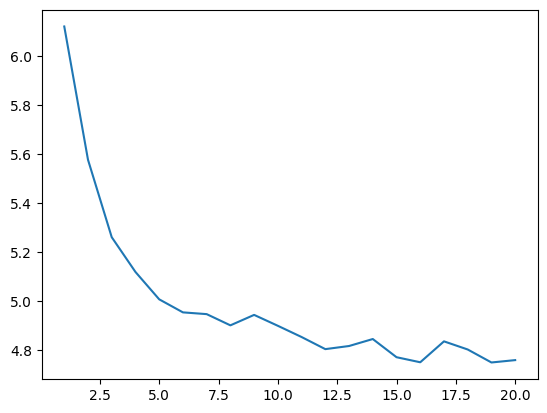

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

#### Perplejidad v/s Épocas

En la figura se muestra la evolución de la perplejidad en el conjunto de validación a lo largo de 20 épocas de entrenamiento. Se observa una caída pronunciada durante las primeras épocas (de ≈6.2 a ≈5.0), seguida de una disminución más lenta hasta valores cercanos a 4.8. A partir de la época ~10 las mejoras son marginales y la curva presenta pequeñas oscilaciones, lo que indica que el modelo se aproxima a su punto de convergencia para esta arquitectura y conjunto de hiperparámetros.

In [48]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.keras')


### 5. Generación de texto con greedy search

In [25]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [26]:
input_text='habló así: '

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'habló así: «¡ay, al hombre su alma de la '

###  6. Generación de texto con beam search determinista

In [27]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [28]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

In [44]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="habló así: ")

In [45]:
salidas[0]

array([13, 27, 32, 15, 24, 44, 27, 42, 21, 47, 44, 11, 56, 26, 36, 48, 44,
       35, 43, 34, 22, 60,  2, 27, 44, 62, 46, 44, 15, 27, 44])

In [46]:
# veamos las salidas
decode(salidas[0])

'habló así: «¡qué importa de la '

### 7. Beam search estocástico y efecto de la temperatura

In [ ]:
# Beam search estocástico: efecto de la temperatura

contexto = "habló así: "
temperaturas = [0.1, 1, 5.0, 100.0]

for temp in temperaturas:
    print("="*80)
    print(f"Temperatura = {temp}")
    print("-"*80)
    
    # beam search estocástico (mode='sto')
    salidas_sto = beam_search(
        model,
        num_beams=10,      # cuántos haces
        num_words=80,     # cuántos caracteres nuevos 
        input=contexto,
        temp=temp,
        mode='sto'
    )
    
    # algunas muestras
    for i in range(3):
        print(f"Muestra {i+1}:")
        print(decode(salidas_sto[i]))
        print()


Temperatura = 0.1
--------------------------------------------------------------------------------
Muestra 1:
habló así: «¡qué importa en el mundo de la vida de la vida de la vida de la vida de la vida

Muestra 2:
habló así: «¡qué importa en el mundo de la vida de la vida de la vida de la vida de la vida

Muestra 3:
habló así: «¡qué importa en el mundo de la vida de la vida de la vida de la vida de la vida

Temperatura = 1
--------------------------------------------------------------------------------
Muestra 1:
habló así: «¡qué importa mismo que los ojos de la vida de la virtud es mismo encontrado de 

Muestra 2:
habló así: «¡qué importa mismo que los ojos de la vida de la virtud es mismo en lo que la v

Muestra 3:
habló así: «¡qué importa mismo que los ojos de la vida de la virtud es mismo en lo que la o

Temperatura = 5.0
--------------------------------------------------------------------------------
Muestra 1:
habló así: huevidosas: pudie tú he buen soyan láspeto! ocuna selto a o



Se probó beam search estocástico con temperaturas 0.1, 1.0, 5.0, y 100.0.

- Con **temperatura 0.1** las secuencias generadas son más conservadoras y repetitivas: el modelo tiende a elegir siempre los caracteres más probables.
- Con **temperatura 1.0** hay un equilibrio entre menos repetición y coherencia.
- Con **temperatura 5.0** la generación se vuelve muy aleatoria y resulta en pocas palabras del idioma base y mucha "jerigonza".
- Con **temperatura 100.0** la generación se vuelve casi totalmente aleatoria y el texto pierde toda coherencia.

Esto permite observar la relación entre la temperatura, calidad y menor repetición en las secuencias generadas.
